In [1]:
key = ''
import requests
import json, os
import urllib.request
from shapely.geometry import Point, Polygon
from matplotlib import pyplot as plt
import shapely
import pickle
import random
import numpy as np
import gmaps
dataDir = "/geoguessr/data/images"

In [2]:
def plotMap(polyGrid, Loc=[], restrict=[]):
    gPoly = []
    sLoc = []
    sHtext = []
    if len(restrict)==0:
        restrict = list(polyGrid.keys())
        
    for k,v in polyGrid.items():
        if k in restrict:
            gPoly.append(gmaps.Polygon(
                            list(v),
                            stroke_color='yellow',
                            fill_color='green'
                            ))
            sLoc.append((v[0][0],v[0][1]))
            sHtext.append(str(k))
    
    if len(Loc)!=0:
        sLoc = []
        sHtext = []
        for k,v in Loc.items():
            if k in restrict:
                sLoc += v
                sHtext += [str(k)+str(i) for i in v]
        
    fig = gmaps.figure(center=(39.50,-98.35), zoom_level=4, map_type='TERRAIN')
    fig.add_layer(gmaps.drawing_layer(features=gPoly))
    fig.add_layer(gmaps.symbol_layer(sLoc,info_box_content = sHtext, scale = 1))
    return fig

65


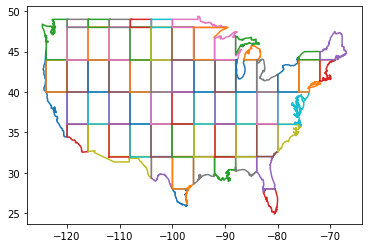

In [3]:
#Load list of polygons containing us map created in grid creation notebook
mainlandGrid = pickle.load(open("mainlandGrid.pickle",'rb'))
for i in mainlandGrid.values():
    plt.plot(i[:,1],i[:,0])
print(len(mainlandGrid))

In [4]:
# restrict grids for which data has to collected from. Otherwise data is scraped from all grids
searchGrids = mainlandGrid.keys()
# searchGrids = list(range(235,244))
print("Search in Grids: {}".format("All" if searchGrids==mainlandGrid.keys() else searchGrids))

Search in Grids: All


In [5]:
base = 'https://maps.googleapis.com/maps/api/streetview'
ext = '?size=400x200&location={}&fov=100&heading={}&radius={}&pitch=10&key={}'
print("Seacrchin Grids: {}".format("All" if searchGrids==mainlandGrid.keys() else searchGrids))
for grid,coor in mainlandGrid.items():        
    poly = Polygon(np.flip(coor))
    minx, miny, maxx, maxy = poly.bounds
    count = 0
    trials = 0
    locList = []
    if grid in searchGrids:
        saveFolder = dataDir
        if os.path.exists(saveFolder)==False:
            os.mkdir(saveFolder)
        locList = os.listdir(saveFolder)
        print("################## Searching grid {} ###################".format(grid))
        imgnum = 0
        while count<1 and trials<4:
            pnt = Point(random.uniform(minx, maxx), random.uniform(miny, maxy))
            location = str(pnt.y)+','+str(pnt.x)
            if (poly.contains(pnt)) and (location not in locList):
                metaUrl = base + '/metadata' + ext.format(location, 0, 10000, key)
                r = requests.get(metaUrl).json()
                trials += 1
                print("Trial: {}, count: {}".format(trials,count))
                if r['status']=='OK' and poly.contains(Point(r['location']['lng'],r['location']['lat'])):
                    location = str(r['location']['lat'])+','+str(r['location']['lng'])
                    if (location not in locList):
                        print("Valid location found: {}".format(location))
                        locList.append(location)
                        saveFile = saveFolder
                        if os.path.exists(saveFile)==False:
                            os.mkdir(saveFile)

                        for heading in [0,90,180]:
                            imgUrl = base + ext.format(location, heading, 10000, key)
                            urllib.request.urlretrieve(imgUrl,saveFile+'/{}_{}.jpg'.format(grid,imgnum))
                            imgnum += 1
                        count += 1
                        trials = 0
                    else:
                        print("Failed trial {} location exists".format(trials))
                        print("Location {}".format(location))
                else:
                    print("Failed trial {} status or contains".format(trials))
                    print("Location {}".format(location))
        print("No duplicates: {}".format(len(locList)==len(set(locList))))

Seacrchin Grids: All
################## Searching grid 0 ###################
Trial: 1, count: 0
Valid location found: 39.69674913424976,-122.1869587092495
No duplicates: True
################## Searching grid 1 ###################
Trial: 1, count: 0
Valid location found: 40.46817871716893,-120.6109376565539
No duplicates: True
################## Searching grid 2 ###################
Trial: 1, count: 0
Failed trial 1 status or contains
Location 46.40749418479597,-120.94748543759056
Trial: 2, count: 0
Valid location found: 44.0870523,-121.6272962
No duplicates: True
################## Searching grid 3 ###################
Trial: 1, count: 0
Valid location found: 34.2238173,-117.5261025
No duplicates: True
################## Searching grid 4 ###################
Trial: 1, count: 0
Valid location found: 39.26575564922069,-117.7113052971649
No duplicates: True
################## Searching grid 5 ###################
Trial: 1, count: 0
Valid location found: 41.7527881,-118.840839
No duplicates: 